# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,ReLU,LeakyReLU,Softmax,Flatten,BatchNormalization
from tensorflow.keras.callbacks import Callback,EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Softmax
from scipy.io import loadmat

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [4]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [5]:
print(train.keys())
x_train = train['X']
y_train = train['y']

print(test.keys())
x_test = test["X"]
y_test = test["y"]

x_train.shape,x_test.shape,y_train.shape,y_test.shape


dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


((32, 32, 3, 73257), (32, 32, 3, 26032), (73257, 1), (26032, 1))

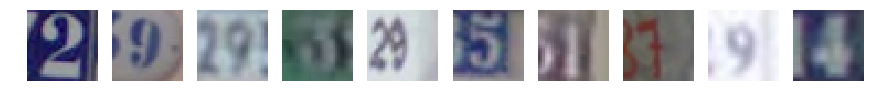

In [4]:
fig,ax = plt.subplots(nrows = 1,ncols= 10,figsize=(15,5))
for i in range(10):
    chooserandom = np.random.choice(x_train.shape[3])
    images = x_train[:,:,:,chooserandom]
    ax[i].imshow(images)
    ax[i].set_axis_off()

In [6]:
x_trainingray = np.mean(x_train,axis = 2,keepdims=True)
x_testgray = np.mean(x_test,axis = 2,keepdims=True)
x_trainingray = np.moveaxis(x_trainingray,2,0)
x_testgray = np.moveaxis(x_testgray,2,0)
x_trainingray = np.moveaxis(x_trainingray,3,0)
x_testgray =np.moveaxis(x_testgray,3,0)
x_trainingray.shape,x_testgray.shape

x_trainingray = x_trainingray / 255.0
x_testgray = x_testgray / 255.

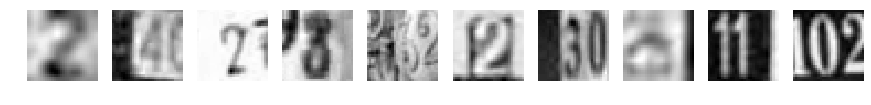

In [6]:
fig,ax = plt.subplots(nrows = 1,ncols= 10,figsize=(15,5))
for i in range(10):
    chooserandom = np.random.choice(x_trainingray.shape[0])
    images = x_trainingray[chooserandom,0,:,:,]
    ax[i].imshow(images,cmap = "gray")
    ax[i].set_axis_off()

In [7]:
y_train = y_train - 1
y_test = y_test -1 
y_train = to_categorical(y_train,num_classes=10)
y_test =to_categorical(y_test,num_classes =10)

In [8]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [8]:
def buildmodel(input_shape,epochs,lr):
    model = Sequential([
        Flatten(input_shape = input_shape,name="Flattening",data_format="channels_first"),
        Dense(units =128,activation = LeakyReLU(),name = "dense_1",kernel_initializer=initializers.he_normal(),
              bias_initializer=initializers.Ones()),
        Dense(units =128,activation = LeakyReLU(),name = "dense_2",kernel_initializer=initializers.he_normal(),
              bias_initializer=initializers.Ones()),
        Dense(units =128,activation = ReLU(),name = "dense_3",kernel_initializer=initializers.he_normal(),
              bias_initializer=initializers.Ones()),
        Dense(units = 10,activation = Softmax(),name = "Output")
    ],name = "SampisModel")
    METRICS = [tf.keras.metrics.TruePositives(name="TP"),
              tf.keras.metrics.TrueNegatives(name="TN"),
              tf.keras.metrics.FalsePositives(name="FP"),
              tf.keras.metrics.FalseNegatives(name="FN"),
              tf.keras.metrics.CategoricalAccuracy(name="ACC"),
              tf.keras.metrics.AUC(name="AUC")]
   
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(loss=loss,optimizer=optimizer,metrics=METRICS)
    
    return model


In [9]:
shape = x_trainingray[0,:,:,:].shape
model = buildmodel(shape,30,0.001)
model.summary()

Model: "SampisModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flattening (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
Output (Dense)               (None, 10)                1290      
Total params: 165,514
Trainable params: 165,514
Non-trainable params: 0
_________________________________________________________________


In [11]:
def EarlyStopme():
    
    earlystop = EarlyStopping(monitor = "val_loss",patience=8,verbose=1)
    
    return earlystop


def create_learning_rate_scheduler(max_learn_rate=0.001,
                                   end_learn_rate = 0.0005,
                                   warmup_epoch_count=5,
                                   total_epoch_count=15):

    def lr_scheduler(epoch):
        if epoch < warmup_epoch_count:
            res = (max_learn_rate)
        else:
            res = max_learn_rate*math.exp(math.log(end_learn_rate/max_learn_rate)*(epoch-warmup_epoch_count+1)/(total_epoch_count-warmup_epoch_count+1))
        return float(res)
    learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

    return learning_rate_scheduler
def CheckpointDude():
    Checkpointpath = "checkpointmodel/CheckpointBest"
    Checkpoint = ModelCheckpoint(filepath=Checkpointpath,monitor = "val_loss",
                                save_best_only = True,save_weights_only=True,frequency = "epochs",verbose=1)
    return Checkpoint

checkpoint = CheckpointDude()
EarlyStop = EarlyStopme()
scheduler = create_learning_rate_scheduler()

In [12]:


history = model.fit(x = x_trainingray,y=y_train,epochs=15,
          verbose=1,batch_size= 64,
           workers = -1,validation_data=[x_testgray,y_test],
         callbacks=[EarlyStop,scheduler,checkpoint])

Train on 73257 samples, validate on 26032 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/15
73216/73257 [============================>.] - ETA: 0s - loss: 1.8694 - TP: 11535.0000 - TN: 655446.0000 - FP: 3498.0000 - FN: 61681.0000 - ACC: 0.3470 - AUC: 0.7616
Epoch 00001: val_loss improved from inf to 1.33333, saving model to checkpointmodel/CheckpointBest
73257/73257 [==============================] - 48s 661us/sample - loss: 1.8689 - TP: 11557.0000 - TN: 655812.0000 - FP: 3501.0000 - FN: 61700.0000 - ACC: 0.3472 - AUC: 0.7617 - val_loss: 1.3333 - val_TP: 11391.0000 - val_TN: 230593.0000 - val_FP: 3695.0000 - val_FN: 14641.0000 - val_ACC: 0.5788 - val_AUC: 0.8935

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/15
73152/73257 [============================>.] - ETA: 0s - loss: 1.1363 - TP: 36950.0000 - TN: 649781.0000 - FP: 8587.0000 - FN: 36202.0000 - ACC: 0.6376 - AUC: 0.9216
Epoch 00002: val_loss improved from 1.33333 t

73088/73257 [============================>.] - ETA: 0s - loss: 0.5789 - TP: 56095.0000 - TN: 651478.0000 - FP: 6314.0000 - FN: 16993.0000 - ACC: 0.8239 - AUC: 0.9778
Epoch 00013: val_loss did not improve from 0.73762
73257/73257 [==============================] - 44s 603us/sample - loss: 0.5787 - TP: 56230.0000 - TN: 652988.0000 - FP: 6325.0000 - FN: 17027.0000 - ACC: 0.8239 - AUC: 0.9778 - val_loss: 0.7702 - val_TP: 19100.0000 - val_TN: 231054.0000 - val_FP: 3234.0000 - val_FN: 6932.0000 - val_ACC: 0.7847 - val_AUC: 0.9620

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0005671562610977313.
Epoch 14/15
73216/73257 [============================>.] - ETA: 0s - loss: 0.5600 - TP: 56869.0000 - TN: 652692.0000 - FP: 6252.0000 - FN: 16347.0000 - ACC: 0.8303 - AUC: 0.9791
Epoch 00014: val_loss improved from 0.73762 to 0.72354, saving model to checkpointmodel/CheckpointBest
73257/73257 [==============================] - 45s 608us/sample - loss: 0.5600 - TP: 56903.0000 - TN: 65

[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'epochs'),
 Text(0.5, 1.0, 'Accuracy Perfomance')]

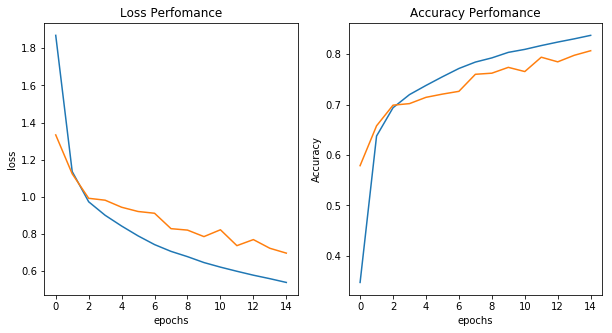

In [13]:
df = pd.DataFrame(history.history)

f,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(df["loss"])
ax[0].plot(df["val_loss"])
ax[0].set(title="Loss Perfomance",ylabel = "loss",xlabel="epochs")

ax[1].plot(df["ACC"])
ax[1].plot(df["val_ACC"])
ax[1].set(title="Accuracy Perfomance",ylabel = "Accuracy",xlabel="epochs")

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [10]:
def buildmodelCnn(input_shape):
    model = Sequential([
        Conv2D(filters = 16,kernel_size=(3,3),padding = "SAME",input_shape = input_shape,
              activation = LeakyReLU()),
        MaxPooling2D(pool_size=(7,7)),
        BatchNormalization(),
        Flatten(),
        Dense(units =128,activation = LeakyReLU(),name = "dense_1",kernel_initializer=initializers.he_normal(),
              bias_initializer=initializers.Ones()),
        Dense(units =128,activation = LeakyReLU(),name = "dense_2",kernel_initializer=initializers.he_normal(),
              bias_initializer=initializers.Ones()),
        Dense(units =128,activation = ReLU(),name = "dense_3",kernel_initializer=initializers.he_normal(),
              bias_initializer=initializers.Ones()),
        Dense(units = 10,activation = Softmax(),name = "Output")
        
    ])
    opt = tf.keras.optimizers.Adam(0.001)
    loss = tf.keras.losses.CategoricalCrossentropy()
    METRICS = [tf.keras.metrics.TruePositives(name="TP"),
          tf.keras.metrics.TrueNegatives(name="TN"),
          tf.keras.metrics.FalsePositives(name="FP"),
          tf.keras.metrics.FalseNegatives(name="FN"),
          tf.keras.metrics.CategoricalAccuracy(name="ACC"),
          tf.keras.metrics.AUC(name="AUC")]
    
    model.compile(optimizer=opt,loss=loss,metrics=METRICS)
    
    return model
    

In [11]:

x_trainingray = np.moveaxis(x_trainingray,1,3)
x_testgray =np.moveaxis(x_testgray,1,3)
print(x_trainingray.shape,x_testgray.shape)
shape = x_trainingray[0,:,:,:].shape
print(shape)
modelcnn = buildmodelCnn(shape)
modelcnn.summary()

(73257, 32, 32, 1) (26032, 32, 32, 1)
(32, 32, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 16)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 16)          64        
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_

In [16]:
def CheckpointCNNDude():
    Checkpointpath = "checkpointmodelCNN/CheckpointBest"
    Checkpoint = ModelCheckpoint(filepath=Checkpointpath,monitor = "val_loss",
                                save_best_only = True,save_weights_only=True,frequency = "epochs",verbose=1)
    return Checkpoint
checkpoint = CheckpointCNNDude()
EarlyStop = EarlyStopme()
scheduler = create_learning_rate_scheduler()

In [17]:
history = modelcnn.fit(x = x_trainingray,y=y_train,epochs=15,
          verbose=1,batch_size= 64,
           workers = -1,validation_data=[x_testgray,y_test],
         callbacks=[EarlyStop,scheduler,checkpoint])

Train on 73257 samples, validate on 26032 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/15
73216/73257 [============================>.] - ETA: 0s - loss: 1.0940 - TP: 37400.0000 - TN: 650491.0000 - FP: 7877.0000 - FN: 35752.0000 - ACC: 0.6439 - AUC: 0.9288- ETA: 1s - loss: 1.0965 - TP: 37020.0000 - TN: 645375.0000 - FP: 7809.0000 - FN: 35556.0000 - ACC: 0.6431 - A - ETA: 0s - loss: 1.0937 - TP: 37442.0000 - TN: 651055.0000 - FP: 7889.0000 - FN: 35774.0000 - ACC: 0.6440 - AUC: 0.9288
Epoch 00001: val_loss improved from inf to 0.90075, saving model to checkpointmodelCNN/CheckpointBest
73257/73257 [==============================] - 163s 2ms/sample - loss: 1.0935 - TP: 37471.0000 - TN: 651422.0000 - FP: 7891.0000 - FN: 35786.0000 - ACC: 0.6440 - AUC: 0.9288 - val_loss: 0.9008 - val_TP: 16830.0000 - val_TN: 230309.0000 - val_FP: 3979.0000 - val_FN: 9202.0000 - val_ACC: 0.7163 - val_AUC: 0.9511

Epoch 00002: LearningRateScheduler reducing learning rate 

73216/73257 [============================>.] - ETA: 0s - loss: 0.3411 - TP: 63306.0000 - TN: 654220.0000 - FP: 4724.0000 - FN: 9910.0000 - ACC: 0.8934 - AUC: 0.9913
Epoch 00012: val_loss improved from 0.52354 to 0.52262, saving model to checkpointmodelCNN/CheckpointBest
73257/73257 [==============================] - 158s 2ms/sample - loss: 0.3411 - TP: 63340.0000 - TN: 654584.0000 - FP: 4729.0000 - FN: 9917.0000 - ACC: 0.8934 - AUC: 0.9913 - val_loss: 0.5226 - val_TP: 21232.0000 - val_TN: 231664.0000 - val_FP: 2624.0000 - val_FN: 4800.0000 - val_ACC: 0.8460 - val_AUC: 0.9810

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0006040447222022236.
Epoch 13/15
73216/73257 [============================>.] - ETA: 0s - loss: 0.3280 - TP: 63752.0000 - TN: 654420.0000 - FP: 4524.0000 - FN: 9464.0000 - ACC: 0.8978 - AUC: 0.9919
Epoch 00013: val_loss did not improve from 0.52262
73257/73257 [==============================] - 154s 2ms/sample - loss: 0.3280 - TP: 63786.0000 - TN: 6547

[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'epochs'),
 Text(0.5, 1.0, 'Accuracy Perfomance')]

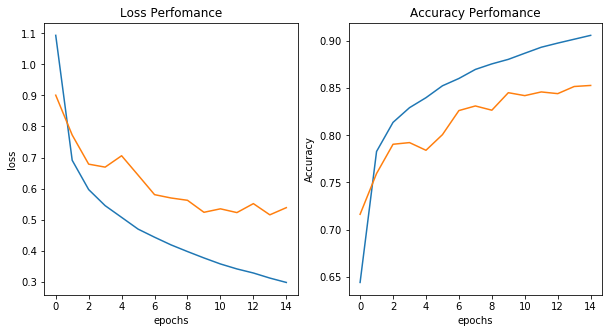

In [18]:
df = pd.DataFrame(history.history)

f,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(df["loss"])
ax[0].plot(df["val_loss"])
ax[0].set(title="Loss Perfomance",ylabel = "loss",xlabel="epochs")

ax[1].plot(df["ACC"])
ax[1].plot(df["val_ACC"])
ax[1].set(title="Accuracy Perfomance",ylabel = "Accuracy",xlabel="epochs")

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [12]:
modelcnn.load_weights(tf.train.latest_checkpoint("checkpointmodelCNN"))
model.load_weights(tf.train.latest_checkpoint("checkpointmodel"))

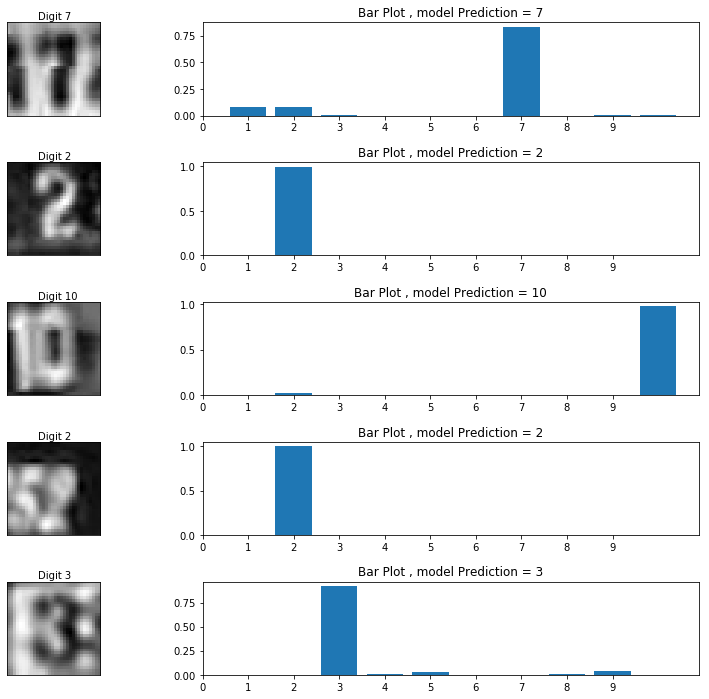

In [13]:
def get_label(labelList):
    iterat = 0
    for i in labelList:
        if i - 1 == 0 :
            return iterat + 1
        iterat = iterat + 1
    return 0

np.random.seed(15)

x_testforMlP = np.moveaxis(x_testgray,3,1)
chooseIndex = np.random.choice(x_testforMlP.shape[0],5)

f,ax = plt.subplots(nrows = 5,ncols = 2,figsize=(16,12))
f.subplots_adjust(hspace=0.5,wspace=-0.2)
for iterate,index in enumerate(chooseIndex):
    LabelsMe = get_label(y_test[index,...])
    images = x_testgray[index,:,:,0]
    prediction = model.predict(np.expand_dims(x_testforMlP[index,:,:,:],axis=0)).reshape(10)
    ax[iterate,0].imshow((images),cmap="gray")
    ax[iterate,0].text(10, -1.5, f"Digit {LabelsMe}")
    ax[iterate,0].get_xaxis().set_visible(False)
    ax[iterate,0].get_yaxis().set_visible(False)
    ax[iterate,1].bar(np.arange(len(prediction))+1, prediction.reshape(10))
    ax[iterate,1].set_xticks(np.arange(len(prediction)))
    ax[iterate,1].set_title(f"Bar Plot , model Prediction = {np.argmax(prediction) + 1}")


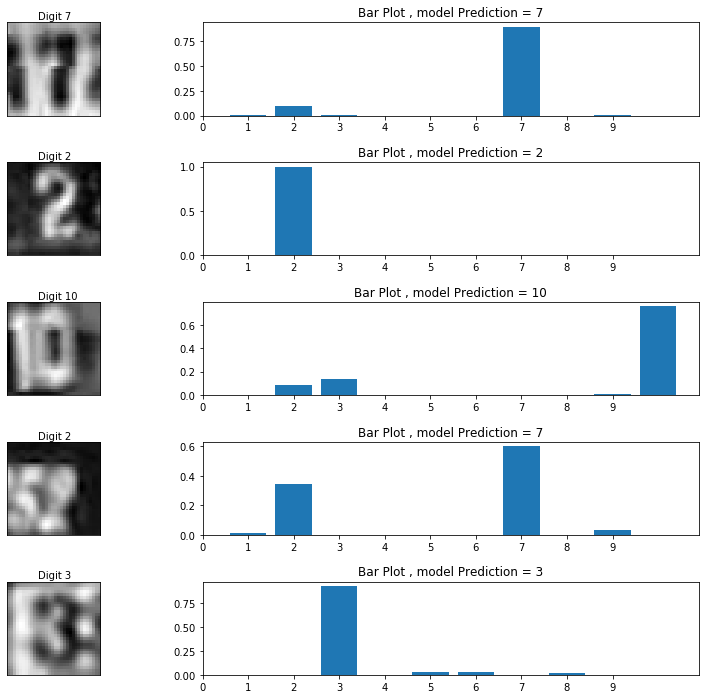

In [14]:
np.random.seed(15)

#x_testforMlP = np.moveaxis(x_testgray,3,1)
chooseIndex = np.random.choice(x_testgray.shape[0],5)

f,ax = plt.subplots(nrows = 5,ncols = 2,figsize=(16,12))
f.subplots_adjust(hspace=0.5,wspace=-0.2)
for iterate,index in enumerate(chooseIndex):
    LabelsMe = get_label(y_test[index,...])
    images = x_testgray[index,:,:,0]
    prediction = modelcnn.predict(np.expand_dims(x_testgray[index,:,:,:],axis=0)).reshape(10)
    ax[iterate,0].imshow((images),cmap="gray")
    ax[iterate,0].text(10, -1.5, f"Digit {LabelsMe}")
    ax[iterate,0].get_xaxis().set_visible(False)
    ax[iterate,0].get_yaxis().set_visible(False)
    ax[iterate,1].bar(np.arange(len(prediction))+1, prediction.reshape(10))
    ax[iterate,1].set_xticks(np.arange(len(prediction)))
    ax[iterate,1].set_title(f"Bar Plot , model Prediction = {np.argmax(prediction) + 1}")
